In [1]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score



import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn.functional as F

from transformers import BertTokenizer, BertModel

import cv2
from PIL import Image

import os
from tqdm import tqdm

import re
from io import StringIO

import time
from torch.optim.lr_scheduler import ReduceLROnPlateau


**Paramètres**

In [3]:
SEED = 42
BATCH_SIZE = 64 
NUM_EPOCHS = 11
LEARNING_RATE = 3e-4 #0.0003
IMAGE_SIZE = 256
MAX_TEXT_LENGTH = 128
NUM_LABELS = 19  

TRAIN_CSV_PATH = '/kaggle/input/multi-label-classification-competition-2023/COMP5329S1A2Dataset/train.csv'
TEST_CSV_PATH = '/kaggle/input/multi-label-classification-competition-2023/COMP5329S1A2Dataset/test.csv'
IMAGES_DIR = '/kaggle/input/multi-label-classification-competition-2023/COMP5329S1A2Dataset/data'

# Configuration du device (gpu p100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.manual_seed(SEED)
np.random.seed(SEED)

Using device: cpu


# **Chargement et prétraitement des data**

In [4]:
def load_data(csv_path):
    with open(csv_path, 'r') as file:
        lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    
    df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
    
    if 'Labels' in df.columns:
        df['Labels'] = df['Labels'].fillna('')
    
    return df

train_df = load_data(TRAIN_CSV_PATH)
test_df = load_data(TEST_CSV_PATH)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\nTrain DataFrame columns:")
print(train_df.columns)
print("\nTest DataFrame columns:")
print(test_df.columns)

print("\nTrain DataFrame - First 5 rows:")
print(train_df.head())

print("\nTest DataFrame - First 5 rows:")
print(test_df.head())

print("\nMissing values in Train DataFrame:")
print(train_df.isnull().sum())
print("\nMissing values in Test DataFrame:")
print(test_df.isnull().sum())

Train data shape: (29996, 3)
Test data shape: (10000, 2)

Train DataFrame columns:
Index(['ImageID', 'Labels', 'Caption'], dtype='object')

Test DataFrame columns:
Index(['ImageID', 'Caption'], dtype='object')

Train DataFrame - First 5 rows:
  ImageID  Labels                                            Caption
0   0.jpg       1   Woman in swim suit holding parasol on sunny day.
1   1.jpg    1 19  A couple of men riding horses on top of a gree...
2   2.jpg       1  They are brave for riding in the jungle on tho...
3   3.jpg  8 3 13  a black and silver clock tower at an intersect...
4   4.jpg   8 3 7   A train coming to a stop on the tracks out side.

Test DataFrame - First 5 rows:
     ImageID                                            Caption
0  30000.jpg  A little girl waring a krispy kreme hat holdin...
1  30001.jpg  A beautiful young woman holding an orange fris...
2  30002.jpg  A group of people sitting on couch next to a c...
3  30003.jpg         A person on a snowboard rides on t

In [5]:
image_dir = '/kaggle/input/multi-label-classification-competition-2023/COMP5329S1A2Dataset/data'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
print(f"Nombre d'images dans le dossier : {len(image_files)}")

Nombre d'images dans le dossier : 40000


# **Transformation d'image et tokenizer**

In [6]:
image_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Fonction pour encoder les labels
def encode_labels(labels_str):
    labels = [int(label) for label in labels_str.split() if label != '12']
    encoded = torch.zeros(NUM_LABELS)
    for label in labels:
        if 1 <= label <= NUM_LABELS:
            encoded[label-1] = 1  
    return encoded

# Fonction pour vérifier la distribution des labels (à garder pour référence future)
def check_label_distribution(dataframe):
    all_labels = dataframe['Labels'].str.split().explode()
    label_counts = all_labels.value_counts().sort_index()
    print("Label distribution:")
    print(label_counts)
    print(f"\nUnique labels: {sorted(label_counts.index.astype(int))}")
    print(f"Min label: {label_counts.index.astype(int).min()}")
    print(f"Max label: {label_counts.index.astype(int).max()}")

In [7]:
# image_transforms = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# # Fonction pour encoder les labels
# def encode_labels(labels_str):
#     labels = [int(label) for label in labels_str.split() if label != '12']
#     encoded = torch.zeros(NUM_LABELS)
#     for label in labels:
#         if 1 <= label <= NUM_LABELS:
#             encoded[label-1] = 1  
#     return encoded

# # Fonction pour vérifier la distribution des labels (à garder pour référence future)
# def check_label_distribution(dataframe):
#     all_labels = dataframe['Labels'].str.split().explode()
#     label_counts = all_labels.value_counts().sort_index()
#     print("Label distribution:")
#     print(label_counts)
#     print(f"\nUnique labels: {sorted(label_counts.index.astype(int))}")
#     print(f"Min label: {label_counts.index.astype(int).min()}")
#     print(f"Max label: {label_counts.index.astype(int).max()}")

In [8]:
check_label_distribution(train_df)

Label distribution:
Labels
1     22794
10     1471
11      604
13      605
14      251
15     1934
16     1099
17     1430
18     1525
19     1020
2      1162
3      4364
4      1272
5      1130
6      1394
7      1221
8      2210
9      1042
Name: count, dtype: int64

Unique labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19]
Min label: 1
Max label: 19


# **Dataset Personnalisé**

In [9]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row['ImageID'])
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        caption = row['Caption']
        encoded_caption = tokenizer(caption, padding='max_length', max_length=MAX_TEXT_LENGTH, truncation=True, return_tensors='pt')
        
        if 'Labels' in row:
            labels = encode_labels(row['Labels'])
            return image, encoded_caption, labels
        else:
            return image, encoded_caption

In [10]:
# Split
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

# Dataset
train_dataset = MultiModalDataset(train_df, IMAGES_DIR, transform=image_transforms)
val_dataset = MultiModalDataset(val_df, IMAGES_DIR, transform=image_transforms)
test_dataset = MultiModalDataset(test_df, IMAGES_DIR, transform=image_transforms)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
print(f"Training examples: {len(train_df)}")
print(f"Validation examples: {len(val_df)}")
print(f"Testing examples: {len(test_df)}")

Training examples: 23996
Validation examples: 6000
Testing examples: 10000


# **Modèle (efficientnet_v2_s & DeBerta)**

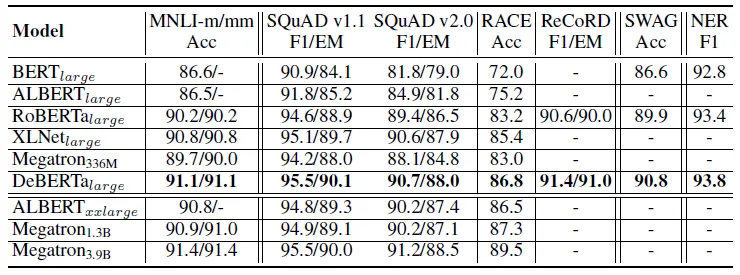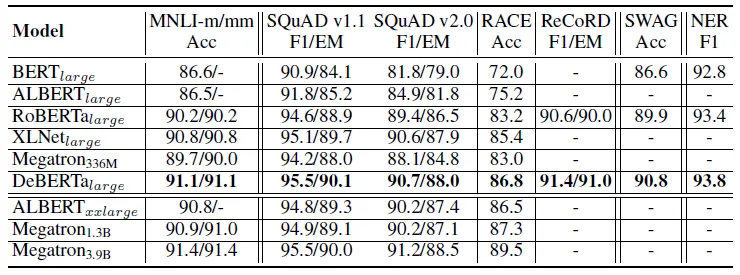

[source](https://sh-tsang.medium.com/brief-review-deberta-decoding-enhanced-bert-with-disentangled-attention-f5cdb9a8bf0b)

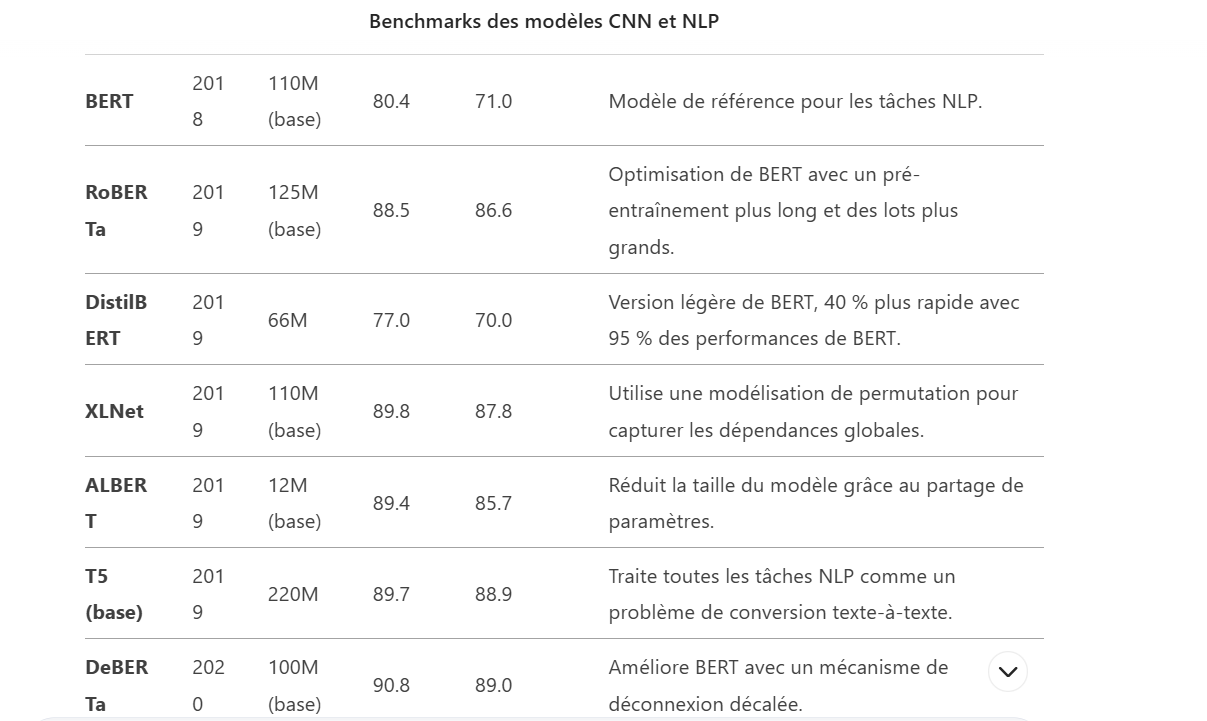


année, paramètres, score glue, score superglue, commentaire

In [12]:
from torchvision.models import efficientnet_v2_s
from transformers import AutoTokenizer, AutoModel

In [13]:
# import torch.nn as nn
# import torchvision.models as models

# class MultimodalModel(nn.Module):
#     def __init__(self, num_labels):
#         super(MultimodalModel, self).__init__()
        
#         # Vision: EfficientNetV2-S
#         self.vision_model = models.efficientnet_v2_s(weights='IMAGENET1K_V1')
#         self.vision_model.classifier = nn.Sequential(
#             nn.Linear(1280, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Ajout de Dropout
#             nn.Linear(512, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Ajout de Dropout
#         )
        
#         # Texte: BERT
#         self.text_model = BertModel.from_pretrained("bert-base-uncased")
#         self.text_fc = nn.Sequential(
#             nn.Linear(768, 256),
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Ajout de Dropout
#         )
        
#         # Fusion des features des deux modèles
#         self.fc = nn.Sequential(
#             nn.Linear(256 + 256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),  # Ajout de Dropout
#             nn.Linear(128, num_labels)
#         )
    
#     def forward(self, image, input_ids, attention_mask):
#         vision_features = self.vision_model(image)
#         text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask).pooler_output
#         text_features = self.text_fc(text_features)

#         combined = torch.cat((vision_features, text_features), dim=1)
#         output = self.fc(combined)
        
#         return output


In [14]:
class MultimodalModel(nn.Module):
    def __init__(self, num_labels):
        super().__init__()
        # Vision (EfficientNetV2-S)
        self.vision_model = efficientnet_v2_s(weights="IMAGENET1K_V1")
        self.vision_model.classifier = nn.Identity()  # Features: 1280-dim
        
        # Texte (DeBERTa)
        self.text_model = AutoModel.from_pretrained("microsoft/deberta-base")  # Features: 768-dim
        
        # Fusion par CrossAttention
        self.cross_attention = CrossAttention(dim_image=1280, dim_text=768, embed_dim=512)
        
        # Classifieur (Ajustez la dimension d'entrée)
        self.classifier = nn.Sequential(
            nn.Linear(512 + 1280, 512),  # 512 (attn) + 1280 (image)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_labels)
        )
        
    def forward(self, images, input_ids, attention_mask):
        # Extraction des features
        image_features = self.vision_model(images)                      # (Batch, 1280)
        text_outputs = self.text_model(input_ids, attention_mask)       # (Batch, Seq, 768)
        text_features = text_outputs.last_hidden_state[:, 0, :]         # (Batch, 768)
        
        # Fusion avec CrossAttention
        fused_features = self.cross_attention(image_features, text_features)  # (Batch, 1792)
        
        # Classification
        outputs = self.classifier(fused_features)
        return outputs
        
class CrossAttention(nn.Module):
    def __init__(self, dim_image=1280, dim_text=768, embed_dim=512):
        super().__init__()
        # Projections linéaires pour aligner les dimensions
        self.image_proj = nn.Linear(dim_image, embed_dim)
        self.text_proj = nn.Linear(dim_text, embed_dim)
        # Attention multi-têtes
        self.attention = nn.MultiheadAttention(embed_dim, num_heads=8)
        
    def forward(self, image_features, text_features):
        # Projection des features
        projected_image = self.image_proj(image_features)  # (Batch, Embed)
        projected_text = self.text_proj(text_features)      # (Batch, Embed)
        
        # Formatage pour MultiheadAttention : (Séquence, Batch, Embed)
        projected_image = projected_image.unsqueeze(0)      # (1, Batch, 512)
        projected_text = projected_text.unsqueeze(0)        # (1, Batch, 512)
        
        # Calcul de l'attention (Query=Image, Key/Value=Text)
        attn_output, _ = self.attention(projected_image, projected_text, projected_text)
        attn_output = attn_output.squeeze(0)  # (Batch, 512)
        
        # Fusion avec les features image originales
        fused_features = torch.cat([attn_output, image_features], dim=1)  # (Batch, 512 + 1280)
        return fused_features

model = MultimodalModel(NUM_LABELS).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s] 


In [15]:
# from torchvision.models import efficientnet_v2_s
# from transformers import AutoTokenizer, AutoModel

# class MultimodalModel(nn.Module):
#     def __init__(self, num_labels):
#         super(MultimodalModel, self).__init__()
        
#         # Vision: EfficientNetV2-S
#         self.vision_model = efficientnet_v2_s(weights="IMAGENET1K_V1")
#         # Get the number of features before the classifier
#         vision_features = self.vision_model.classifier[1].in_features  
#         self.vision_model.classifier = nn.Identity()  # Supprimer la dernière couche
       

#         # Texte: DeBERTa
#         self.text_model = AutoModel.from_pretrained("microsoft/deberta-base")
#         text_features = self.text_model.config.hidden_size

#         # Fusion
#         self.classifier = nn.Sequential(
#             nn.Linear(vision_features + text_features, 512),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(512, num_labels)
#         )

#     def forward(self, images, input_ids, attention_mask): # Changed the order of arguments
#         # Texte
#         text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
#         text_embeddings = text_outputs[:, 0, :]  # CLS token

#         # Images
#         image_features = self.vision_model(images)

#         # Concatenation
#         combined_features = torch.cat((text_embeddings, image_features), dim=1)
        
#         # Classification
#         outputs = self.classifier(combined_features)
#         return outputs


# class CrossAttention(nn.Module):
#     def __init__(self, dim_image, dim_text):
#         super(CrossAttention, self).__init__()
#         self.attention = nn.MultiheadAttention(embed_dim=dim_image, num_heads=8)

#     def forward(self, image_features, text_features):
#         image_features = image_features.unsqueeze(0)
#         text_features = text_features.unsqueeze(0)

#         attn_output, _ = self.attention(image_features, text_features, text_features)

#         fused_features = torch.cat([attn_output.squeeze(0), image_features.squeeze(0)], dim=1)
#         return fused_features

# model = MultimodalModel(NUM_LABELS).to(device)

In [16]:
# Affichage des informations sur les datasets et dataloaders
print("TRAINING")
print("training examples: ", len(train_dataset))
print("batch size: ", BATCH_SIZE)
print("batches available: ", len(train_loader))
print()
print("TESTING")
print("validation examples: ", len(val_dataset))
print("batch size: ", BATCH_SIZE)
print("batches available: ", len(val_loader))
print()
print("VALIDATION")
print("testing examples: ", len(test_dataset))
print("batch size: ", BATCH_SIZE)
print("batches available: ", len(test_loader))


TRAINING
training examples:  23996
batch size:  64
batches available:  375

TESTING
validation examples:  6000
batch size:  64
batches available:  94

VALIDATION
testing examples:  10000
batch size:  64
batches available:  157


**Fonction de perte & optimiseur**

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)


**Fonction d'entrainement & évaluation**

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, device, verbose=False):
    model.train()
    total_loss = 0
    total_samples = 0
    
    for batch_idx, (images, captions, labels) in enumerate(tqdm(dataloader)):
        images = images.to(device)
        input_ids = captions['input_ids'].squeeze(1).to(device)
        attention_mask = captions['attention_mask'].squeeze(1).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        batch_size = images.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    return total_loss / total_samples


def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, captions, labels in tqdm(dataloader):
            images = images.to(device)
            input_ids = captions['input_ids'].squeeze(1).to(device)
            attention_mask = captions['attention_mask'].squeeze(1).to(device)
            labels = labels.to(device)
            
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            batch_size = images.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    
    # Concaténation pour calculer le F1-score
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    f1 = f1_score(all_labels, all_preds, average='samples')
    
    return total_loss / total_samples, f1


# **Boucle d'entrainement**

In [19]:
config = {
    'patience': 5,               
    'scheduler_patience': 2,     
    'scheduler_mode': 'max',     
    'model_path': 'best_model.pth', 
    'checkpoint_path': 'checkpoint.pth'  # Nouveau fichier de checkpoint
}

best_f1 = 0
patience_counter = 0

scheduler = ReduceLROnPlateau(optimizer, mode=config['scheduler_mode'], 
                              patience=config['scheduler_patience'], verbose=True)

for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
    epoch_duration = time.time() - start_time
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Duration: {epoch_duration:.2f}s")
    print(f"  Train Loss: {train_loss:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}")
    print(f"  Val F1:     {val_f1:.4f}")
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        # Sauvegarde complète du modèle
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': val_loss
        }, config['checkpoint_path'])  
        print("  Model and optimizer saved!")
        patience_counter = 0  
    else:
        patience_counter += 1
    
    if patience_counter >= config['patience']:
        print("  Early stopping!")
        break
    
    scheduler.step(val_f1)
    
    print()


100%|██████████| 94/94 [03:28<00:00,  2.22s/it]


Epoch 1/11 - Duration: 2660.32s
  Train Loss: 0.1180
  Val Loss:   0.0863
  Val F1:     0.8141
  Model and optimizer saved!



100%|██████████| 94/94 [02:58<00:00,  1.90s/it]


Epoch 2/11 - Duration: 2493.42s
  Train Loss: 0.0849
  Val Loss:   0.0865
  Val F1:     0.8234
  Model and optimizer saved!



100%|██████████| 94/94 [03:18<00:00,  2.11s/it]


Epoch 3/11 - Duration: 2704.34s
  Train Loss: 0.0760
  Val Loss:   0.0886
  Val F1:     0.8086



100%|██████████| 94/94 [03:17<00:00,  2.10s/it]


Epoch 4/11 - Duration: 2715.91s
  Train Loss: 0.0717
  Val Loss:   0.0905
  Val F1:     0.8096



100%|██████████| 94/94 [03:20<00:00,  2.13s/it]


Epoch 5/11 - Duration: 2760.75s
  Train Loss: 0.0690
  Val Loss:   0.0979
  Val F1:     0.7926



100%|██████████| 94/94 [03:23<00:00,  2.16s/it]


Epoch 6/11 - Duration: 2766.41s
  Train Loss: 0.0483
  Val Loss:   0.0816
  Val F1:     0.8448
  Model and optimizer saved!



100%|██████████| 94/94 [03:29<00:00,  2.23s/it]


Epoch 7/11 - Duration: 2775.21s
  Train Loss: 0.0380
  Val Loss:   0.0860
  Val F1:     0.8449
  Model and optimizer saved!



100%|██████████| 94/94 [03:27<00:00,  2.21s/it]


Epoch 8/11 - Duration: 2768.58s
  Train Loss: 0.0323
  Val Loss:   0.0892
  Val F1:     0.8432



100%|██████████| 94/94 [03:17<00:00,  2.10s/it]


Epoch 9/11 - Duration: 2754.02s
  Train Loss: 0.0278
  Val Loss:   0.0939
  Val F1:     0.8448



100%|██████████| 94/94 [03:30<00:00,  2.24s/it]


Epoch 10/11 - Duration: 2758.79s
  Train Loss: 0.0239
  Val Loss:   0.1018
  Val F1:     0.8405



100%|██████████| 94/94 [03:28<00:00,  2.22s/it]


Epoch 11/11 - Duration: 2785.80s
  Train Loss: 0.0200
  Val Loss:   0.1003
  Val F1:     0.8417



In [20]:
# import torch

# checkpoint_path = 'checkpoint.pth'

# try:
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint['epoch'] + 1  # Reprendre à l'époque suivante

#     print(f"Checkpoint chargé : reprise à l'époque {start_epoch}")
    
# except FileNotFoundError:
#     print("Aucun checkpoint trouvé, l'entraînement recommence à zéro.")
#     start_epoch = 0  # Recommencer à zéro si aucun checkpoint

# # Reprendre l'entraînement à partir de start_epoch
# for epoch in range(start_epoch, NUM_EPOCHS):
#     start_time = time.time()
#     train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
#     val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
#     epoch_duration = time.time() - start_time
    
#     print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Duration: {epoch_duration:.2f}s")
#     print(f"  Train Loss: {train_loss:.4f}")
#     print(f"  Val Loss:   {val_loss:.4f}")
#     print(f"  Val F1:     {val_f1:.4f}")
    
#     if val_f1 > best_f1:
#         best_f1 = val_f1
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'scheduler_state_dict': scheduler.state_dict(),
#             'loss': val_loss
#         }, checkpoint_path)  
#         print("  Model and optimizer saved!")
#         patience_counter = 0  
#     else:
#         patience_counter += 1
    
#     if patience_counter >= config['patience']:
#         print("  Early stopping!")
#         break
    
#     scheduler.step(val_f1)
    
#     print()


In [24]:
checkpoint_path = "checkpoint.pth"
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    print("Checkpoint chargé avec succès !")
else:
    print("Aucun checkpoint trouvé, réentraîne le modèle.")


/tmp/ipykernel_10/2255998274.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint chargé avec succès !


In [25]:
import os
print("Fichier trouvé :", os.path.exists("checkpoint.pth"))


Fichier trouvé : True


In [26]:
print("Résumé du Meilleur Modèle Trouvé")
print("-" * 40)
print(f"Meilleur F1-Score (Validation): {best_f1:.4f}")
print("\nHyperparamètres utilisés :")
print(f"  - Nombre d'époques : {NUM_EPOCHS}")
print(f"  - Patience pour Early Stopping : {config['patience']}")
print(f"  - Learning Rate initial : {optimizer.defaults['lr']}")
print(f"  - Scheduler : ReduceLROnPlateau (patience = {config['scheduler_patience']})")

Résumé du Meilleur Modèle Trouvé
----------------------------------------
Meilleur F1-Score (Validation): 0.8449

Hyperparamètres utilisés :
  - Nombre d'époques : 11
  - Patience pour Early Stopping : 5
  - Learning Rate initial : 0.0003
  - Scheduler : ReduceLROnPlateau (patience = 2)


# **Génération des prédictions**

In [29]:
def generate_predictions(model, dataloader, device):
    model.eval()
    all_preds = []
    
    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc="Generating predictions"):
            images = images.to(device)
            input_ids = captions['input_ids'].squeeze(1).to(device)
            attention_mask = captions['attention_mask'].squeeze(1).to(device)
            
            outputs = model(images, input_ids, attention_mask)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.append(preds.cpu())
    
    return torch.cat(all_preds, dim=0)

# Charger le meilleur modèle
model.load_state_dict(torch.load('checkpoint.pth'))
model = model.to(device)
predictions = generate_predictions(model, test_loader, device)

/tmp/ipykernel_10/1538762912.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint.pth'))


RuntimeError: Error(s) in loading state_dict for MultimodalModel:
	Missing key(s) in state_dict: "vision_model.features.0.0.weight", "vision_model.features.0.1.weight", "vision_model.features.0.1.bias", "vision_model.features.0.1.running_mean", "vision_model.features.0.1.running_var", "vision_model.features.1.0.block.0.0.weight", "vision_model.features.1.0.block.0.1.weight", "vision_model.features.1.0.block.0.1.bias", "vision_model.features.1.0.block.0.1.running_mean", "vision_model.features.1.0.block.0.1.running_var", "vision_model.features.1.1.block.0.0.weight", "vision_model.features.1.1.block.0.1.weight", "vision_model.features.1.1.block.0.1.bias", "vision_model.features.1.1.block.0.1.running_mean", "vision_model.features.1.1.block.0.1.running_var", "vision_model.features.2.0.block.0.0.weight", "vision_model.features.2.0.block.0.1.weight", "vision_model.features.2.0.block.0.1.bias", "vision_model.features.2.0.block.0.1.running_mean", "vision_model.features.2.0.block.0.1.running_var", "vision_model.features.2.0.block.1.0.weight", "vision_model.features.2.0.block.1.1.weight", "vision_model.features.2.0.block.1.1.bias", "vision_model.features.2.0.block.1.1.running_mean", "vision_model.features.2.0.block.1.1.running_var", "vision_model.features.2.1.block.0.0.weight", "vision_model.features.2.1.block.0.1.weight", "vision_model.features.2.1.block.0.1.bias", "vision_model.features.2.1.block.0.1.running_mean", "vision_model.features.2.1.block.0.1.running_var", "vision_model.features.2.1.block.1.0.weight", "vision_model.features.2.1.block.1.1.weight", "vision_model.features.2.1.block.1.1.bias", "vision_model.features.2.1.block.1.1.running_mean", "vision_model.features.2.1.block.1.1.running_var", "vision_model.features.2.2.block.0.0.weight", "vision_model.features.2.2.block.0.1.weight", "vision_model.features.2.2.block.0.1.bias", "vision_model.features.2.2.block.0.1.running_mean", "vision_model.features.2.2.block.0.1.running_var", "vision_model.features.2.2.block.1.0.weight", "vision_model.features.2.2.block.1.1.weight", "vision_model.features.2.2.block.1.1.bias", "vision_model.features.2.2.block.1.1.running_mean", "vision_model.features.2.2.block.1.1.running_var", "vision_model.features.2.3.block.0.0.weight", "vision_model.features.2.3.block.0.1.weight", "vision_model.features.2.3.block.0.1.bias", "vision_model.features.2.3.block.0.1.running_mean", "vision_model.features.2.3.block.0.1.running_var", "vision_model.features.2.3.block.1.0.weight", "vision_model.features.2.3.block.1.1.weight", "vision_model.features.2.3.block.1.1.bias", "vision_model.features.2.3.block.1.1.running_mean", "vision_model.features.2.3.block.1.1.running_var", "vision_model.features.3.0.block.0.0.weight", "vision_model.features.3.0.block.0.1.weight", "vision_model.features.3.0.block.0.1.bias", "vision_model.features.3.0.block.0.1.running_mean", "vision_model.features.3.0.block.0.1.running_var", "vision_model.features.3.0.block.1.0.weight", "vision_model.features.3.0.block.1.1.weight", "vision_model.features.3.0.block.1.1.bias", "vision_model.features.3.0.block.1.1.running_mean", "vision_model.features.3.0.block.1.1.running_var", "vision_model.features.3.1.block.0.0.weight", "vision_model.features.3.1.block.0.1.weight", "vision_model.features.3.1.block.0.1.bias", "vision_model.features.3.1.block.0.1.running_mean", "vision_model.features.3.1.block.0.1.running_var", "vision_model.features.3.1.block.1.0.weight", "vision_model.features.3.1.block.1.1.weight", "vision_model.features.3.1.block.1.1.bias", "vision_model.features.3.1.block.1.1.running_mean", "vision_model.features.3.1.block.1.1.running_var", "vision_model.features.3.2.block.0.0.weight", "vision_model.features.3.2.block.0.1.weight", "vision_model.features.3.2.block.0.1.bias", "vision_model.features.3.2.block.0.1.running_mean", "vision_model.features.3.2.block.0.1.running_var", "vision_model.features.3.2.block.1.0.weight", "vision_model.features.3.2.block.1.1.weight", "vision_model.features.3.2.block.1.1.bias", "vision_model.features.3.2.block.1.1.running_mean", "vision_model.features.3.2.block.1.1.running_var", "vision_model.features.3.3.block.0.0.weight", "vision_model.features.3.3.block.0.1.weight", "vision_model.features.3.3.block.0.1.bias", "vision_model.features.3.3.block.0.1.running_mean", "vision_model.features.3.3.block.0.1.running_var", "vision_model.features.3.3.block.1.0.weight", "vision_model.features.3.3.block.1.1.weight", "vision_model.features.3.3.block.1.1.bias", "vision_model.features.3.3.block.1.1.running_mean", "vision_model.features.3.3.block.1.1.running_var", "vision_model.features.4.0.block.0.0.weight", "vision_model.features.4.0.block.0.1.weight", "vision_model.features.4.0.block.0.1.bias", "vision_model.features.4.0.block.0.1.running_mean", "vision_model.features.4.0.block.0.1.running_var", "vision_model.features.4.0.block.1.0.weight", "vision_model.features.4.0.block.1.1.weight", "vision_model.features.4.0.block.1.1.bias", "vision_model.features.4.0.block.1.1.running_mean", "vision_model.features.4.0.block.1.1.running_var", "vision_model.features.4.0.block.2.fc1.weight", "vision_model.features.4.0.block.2.fc1.bias", "vision_model.features.4.0.block.2.fc2.weight", "vision_model.features.4.0.block.2.fc2.bias", "vision_model.features.4.0.block.3.0.weight", "vision_model.features.4.0.block.3.1.weight", "vision_model.features.4.0.block.3.1.bias", "vision_model.features.4.0.block.3.1.running_mean", "vision_model.features.4.0.block.3.1.running_var", "vision_model.features.4.1.block.0.0.weight", "vision_model.features.4.1.block.0.1.weight", "vision_model.features.4.1.block.0.1.bias", "vision_model.features.4.1.block.0.1.running_mean", "vision_model.features.4.1.block.0.1.running_var", "vision_model.features.4.1.block.1.0.weight", "vision_model.features.4.1.block.1.1.weight", "vision_model.features.4.1.block.1.1.bias", "vision_model.features.4.1.block.1.1.running_mean", "vision_model.features.4.1.block.1.1.running_var", "vision_model.features.4.1.block.2.fc1.weight", "vision_model.features.4.1.block.2.fc1.bias", "vision_model.features.4.1.block.2.fc2.weight", "vision_model.features.4.1.block.2.fc2.bias", "vision_model.features.4.1.block.3.0.weight", "vision_model.features.4.1.block.3.1.weight", "vision_model.features.4.1.block.3.1.bias", "vision_model.features.4.1.block.3.1.running_mean", "vision_model.features.4.1.block.3.1.running_var", "vision_model.features.4.2.block.0.0.weight", "vision_model.features.4.2.block.0.1.weight", "vision_model.features.4.2.block.0.1.bias", "vision_model.features.4.2.block.0.1.running_mean", "vision_model.features.4.2.block.0.1.running_var", "vision_model.features.4.2.block.1.0.weight", "vision_model.features.4.2.block.1.1.weight", "vision_model.features.4.2.block.1.1.bias", "vision_model.features.4.2.block.1.1.running_mean", "vision_model.features.4.2.block.1.1.running_var", "vision_model.features.4.2.block.2.fc1.weight", "vision_model.features.4.2.block.2.fc1.bias", "vision_model.features.4.2.block.2.fc2.weight", "vision_model.features.4.2.block.2.fc2.bias", "vision_model.features.4.2.block.3.0.weight", "vision_model.features.4.2.block.3.1.weight", "vision_model.features.4.2.block.3.1.bias", "vision_model.features.4.2.block.3.1.running_mean", "vision_model.features.4.2.block.3.1.running_var", "vision_model.features.4.3.block.0.0.weight", "vision_model.features.4.3.block.0.1.weight", "vision_model.features.4.3.block.0.1.bias", "vision_model.features.4.3.block.0.1.running_mean", "vision_model.features.4.3.block.0.1.running_var", "vision_model.features.4.3.block.1.0.weight", "vision_model.features.4.3.block.1.1.weight", "vision_model.features.4.3.block.1.1.bias", "vision_model.features.4.3.block.1.1.running_mean", "vision_model.features.4.3.block.1.1.running_var", "vision_model.features.4.3.block.2.fc1.weight", "vision_model.features.4.3.block.2.fc1.bias", "vision_model.features.4.3.block.2.fc2.weight", "vision_model.features.4.3.block.2.fc2.bias", "vision_model.features.4.3.block.3.0.weight", "vision_model.features.4.3.block.3.1.weight", "vision_model.features.4.3.block.3.1.bias", "vision_model.features.4.3.block.3.1.running_mean", "vision_model.features.4.3.block.3.1.running_var", "vision_model.features.4.4.block.0.0.weight", "vision_model.features.4.4.block.0.1.weight", "vision_model.features.4.4.block.0.1.bias", "vision_model.features.4.4.block.0.1.running_mean", "vision_model.features.4.4.block.0.1.running_var", "vision_model.features.4.4.block.1.0.weight", "vision_model.features.4.4.block.1.1.weight", "vision_model.features.4.4.block.1.1.bias", "vision_model.features.4.4.block.1.1.running_mean", "vision_model.features.4.4.block.1.1.running_var", "vision_model.features.4.4.block.2.fc1.weight", "vision_model.features.4.4.block.2.fc1.bias", "vision_model.features.4.4.block.2.fc2.weight", "vision_model.features.4.4.block.2.fc2.bias", "vision_model.features.4.4.block.3.0.weight", "vision_model.features.4.4.block.3.1.weight", "vision_model.features.4.4.block.3.1.bias", "vision_model.features.4.4.block.3.1.running_mean", "vision_model.features.4.4.block.3.1.running_var", "vision_model.features.4.5.block.0.0.weight", "vision_model.features.4.5.block.0.1.weight", "vision_model.features.4.5.block.0.1.bias", "vision_model.features.4.5.block.0.1.running_mean", "vision_model.features.4.5.block.0.1.running_var", "vision_model.features.4.5.block.1.0.weight", "vision_model.features.4.5.block.1.1.weight", "vision_model.features.4.5.block.1.1.bias", "vision_model.features.4.5.block.1.1.running_mean", "vision_model.features.4.5.block.1.1.running_var", "vision_model.features.4.5.block.2.fc1.weight", "vision_model.features.4.5.block.2.fc1.bias", "vision_model.features.4.5.block.2.fc2.weight", "vision_model.features.4.5.block.2.fc2.bias", "vision_model.features.4.5.block.3.0.weight", "vision_model.features.4.5.block.3.1.weight", "vision_model.features.4.5.block.3.1.bias", "vision_model.features.4.5.block.3.1.running_mean", "vision_model.features.4.5.block.3.1.running_var", "vision_model.features.5.0.block.0.0.weight", "vision_model.features.5.0.block.0.1.weight", "vision_model.features.5.0.block.0.1.bias", "vision_model.features.5.0.block.0.1.running_mean", "vision_model.features.5.0.block.0.1.running_var", "vision_model.features.5.0.block.1.0.weight", "vision_model.features.5.0.block.1.1.weight", "vision_model.features.5.0.block.1.1.bias", "vision_model.features.5.0.block.1.1.running_mean", "vision_model.features.5.0.block.1.1.running_var", "vision_model.features.5.0.block.2.fc1.weight", "vision_model.features.5.0.block.2.fc1.bias", "vision_model.features.5.0.block.2.fc2.weight", "vision_model.features.5.0.block.2.fc2.bias", "vision_model.features.5.0.block.3.0.weight", "vision_model.features.5.0.block.3.1.weight", "vision_model.features.5.0.block.3.1.bias", "vision_model.features.5.0.block.3.1.running_mean", "vision_model.features.5.0.block.3.1.running_var", "vision_model.features.5.1.block.0.0.weight", "vision_model.features.5.1.block.0.1.weight", "vision_model.features.5.1.block.0.1.bias", "vision_model.features.5.1.block.0.1.running_mean", "vision_model.features.5.1.block.0.1.running_var", "vision_model.features.5.1.block.1.0.weight", "vision_model.features.5.1.block.1.1.weight", "vision_model.features.5.1.block.1.1.bias", "vision_model.features.5.1.block.1.1.running_mean", "vision_model.features.5.1.block.1.1.running_var", "vision_model.features.5.1.block.2.fc1.weight", "vision_model.features.5.1.block.2.fc1.bias", "vision_model.features.5.1.block.2.fc2.weight", "vision_model.features.5.1.block.2.fc2.bias", "vision_model.features.5.1.block.3.0.weight", "vision_model.features.5.1.block.3.1.weight", "vision_model.features.5.1.block.3.1.bias", "vision_model.features.5.1.block.3.1.running_mean", "vision_model.features.5.1.block.3.1.running_var", "vision_model.features.5.2.block.0.0.weight", "vision_model.features.5.2.block.0.1.weight", "vision_model.features.5.2.block.0.1.bias", "vision_model.features.5.2.block.0.1.running_mean", "vision_model.features.5.2.block.0.1.running_var", "vision_model.features.5.2.block.1.0.weight", "vision_model.features.5.2.block.1.1.weight", "vision_model.features.5.2.block.1.1.bias", "vision_model.features.5.2.block.1.1.running_mean", "vision_model.features.5.2.block.1.1.running_var", "vision_model.features.5.2.block.2.fc1.weight", "vision_model.features.5.2.block.2.fc1.bias", "vision_model.features.5.2.block.2.fc2.weight", "vision_model.features.5.2.block.2.fc2.bias", "vision_model.features.5.2.block.3.0.weight", "vision_model.features.5.2.block.3.1.weight", "vision_model.features.5.2.block.3.1.bias", "vision_model.features.5.2.block.3.1.running_mean", "vision_model.features.5.2.block.3.1.running_var", "vision_model.features.5.3.block.0.0.weight", "vision_model.features.5.3.block.0.1.weight", "vision_model.features.5.3.block.0.1.bias", "vision_model.features.5.3.block.0.1.running_mean", "vision_model.features.5.3.block.0.1.running_var", "vision_model.features.5.3.block.1.0.weight", "vision_model.features.5.3.block.1.1.weight", "vision_model.features.5.3.block.1.1.bias", "vision_model.features.5.3.block.1.1.running_mean", "vision_model.features.5.3.block.1.1.running_var", "vision_model.features.5.3.block.2.fc1.weight", "vision_model.features.5.3.block.2.fc1.bias", "vision_model.features.5.3.block.2.fc2.weight", "vision_model.features.5.3.block.2.fc2.bias", "vision_model.features.5.3.block.3.0.weight", "vision_model.features.5.3.block.3.1.weight", "vision_model.features.5.3.block.3.1.bias", "vision_model.features.5.3.block.3.1.running_mean", "vision_model.features.5.3.block.3.1.running_var", "vision_model.features.5.4.block.0.0.weight", "vision_model.features.5.4.block.0.1.weight", "vision_model.features.5.4.block.0.1.bias", "vision_model.features.5.4.block.0.1.running_mean", "vision_model.features.5.4.block.0.1.running_var", "vision_model.features.5.4.block.1.0.weight", "vision_model.features.5.4.block.1.1.weight", "vision_model.features.5.4.block.1.1.bias", "vision_model.features.5.4.block.1.1.running_mean", "vision_model.features.5.4.block.1.1.running_var", "vision_model.features.5.4.block.2.fc1.weight", "vision_model.features.5.4.block.2.fc1.bias", "vision_model.features.5.4.block.2.fc2.weight", "vision_model.features.5.4.block.2.fc2.bias", "vision_model.features.5.4.block.3.0.weight", "vision_model.features.5.4.block.3.1.weight", "vision_model.features.5.4.block.3.1.bias", "vision_model.features.5.4.block.3.1.running_mean", "vision_model.features.5.4.block.3.1.running_var", "vision_model.features.5.5.block.0.0.weight", "vision_model.features.5.5.block.0.1.weight", "vision_model.features.5.5.block.0.1.bias", "vision_model.features.5.5.block.0.1.running_mean", "vision_model.features.5.5.block.0.1.running_var", "vision_model.features.5.5.block.1.0.weight", "vision_model.features.5.5.block.1.1.weight", "vision_model.features.5.5.block.1.1.bias", "vision_model.features.5.5.block.1.1.running_mean", "vision_model.features.5.5.block.1.1.running_var", "vision_model.features.5.5.block.2.fc1.weight", "vision_model.features.5.5.block.2.fc1.bias", "vision_model.features.5.5.block.2.fc2.weight", "vision_model.features.5.5.block.2.fc2.bias", "vision_model.features.5.5.block.3.0.weight", "vision_model.features.5.5.block.3.1.weight", "vision_model.features.5.5.block.3.1.bias", "vision_model.features.5.5.block.3.1.running_mean", "vision_model.features.5.5.block.3.1.running_var", "vision_model.features.5.6.block.0.0.weight", "vision_model.features.5.6.block.0.1.weight", "vision_model.features.5.6.block.0.1.bias", "vision_model.features.5.6.block.0.1.running_mean", "vision_model.features.5.6.block.0.1.running_var", "vision_model.features.5.6.block.1.0.weight", "vision_model.features.5.6.block.1.1.weight", "vision_model.features.5.6.block.1.1.bias", "vision_model.features.5.6.block.1.1.running_mean", "vision_model.features.5.6.block.1.1.running_var", "vision_model.features.5.6.block.2.fc1.weight", "vision_model.features.5.6.block.2.fc1.bias", "vision_model.features.5.6.block.2.fc2.weight", "vision_model.features.5.6.block.2.fc2.bias", "vision_model.features.5.6.block.3.0.weight", "vision_model.features.5.6.block.3.1.weight", "vision_model.features.5.6.block.3.1.bias", "vision_model.features.5.6.block.3.1.running_mean", "vision_model.features.5.6.block.3.1.running_var", "vision_model.features.5.7.block.0.0.weight", "vision_model.features.5.7.block.0.1.weight", "vision_model.features.5.7.block.0.1.bias", "vision_model.features.5.7.block.0.1.running_mean", "vision_model.features.5.7.block.0.1.running_var", "vision_model.features.5.7.block.1.0.weight", "vision_model.features.5.7.block.1.1.weight", "vision_model.features.5.7.block.1.1.bias", "vision_model.features.5.7.block.1.1.running_mean", "vision_model.features.5.7.block.1.1.running_var", "vision_model.features.5.7.block.2.fc1.weight", "vision_model.features.5.7.block.2.fc1.bias", "vision_model.features.5.7.block.2.fc2.weight", "vision_model.features.5.7.block.2.fc2.bias", "vision_model.features.5.7.block.3.0.weight", "vision_model.features.5.7.block.3.1.weight", "vision_model.features.5.7.block.3.1.bias", "vision_model.features.5.7.block.3.1.running_mean", "vision_model.features.5.7.block.3.1.running_var", "vision_model.features.5.8.block.0.0.weight", "vision_model.features.5.8.block.0.1.weight", "vision_model.features.5.8.block.0.1.bias", "vision_model.features.5.8.block.0.1.running_mean", "vision_model.features.5.8.block.0.1.running_var", "vision_model.features.5.8.block.1.0.weight", "vision_model.features.5.8.block.1.1.weight", "vision_model.features.5.8.block.1.1.bias", "vision_model.features.5.8.block.1.1.running_mean", "vision_model.features.5.8.block.1.1.running_var", "vision_model.features.5.8.block.2.fc1.weight", "vision_model.features.5.8.block.2.fc1.bias", "vision_model.features.5.8.block.2.fc2.weight", "vision_model.features.5.8.block.2.fc2.bias", "vision_model.features.5.8.block.3.0.weight", "vision_model.features.5.8.block.3.1.weight", "vision_model.features.5.8.block.3.1.bias", "vision_model.features.5.8.block.3.1.running_mean", "vision_model.features.5.8.block.3.1.running_var", "vision_model.features.6.0.block.0.0.weight", "vision_model.features.6.0.block.0.1.weight", "vision_model.features.6.0.block.0.1.bias", "vision_model.features.6.0.block.0.1.running_mean", "vision_model.features.6.0.block.0.1.running_var", "vision_model.features.6.0.block.1.0.weight", "vision_model.features.6.0.block.1.1.weight", "vision_model.features.6.0.block.1.1.bias", "vision_model.features.6.0.block.1.1.running_mean", "vision_model.features.6.0.block.1.1.running_var", "vision_model.features.6.0.block.2.fc1.weight", "vision_model.features.6.0.block.2.fc1.bias", "vision_model.features.6.0.block.2.fc2.weight", "vision_model.features.6.0.block.2.fc2.bias", "vision_model.features.6.0.block.3.0.weight", "vision_model.features.6.0.block.3.1.weight", "vision_model.features.6.0.block.3.1.bias", "vision_model.features.6.0.block.3.1.running_mean", "vision_model.features.6.0.block.3.1.running_var", "vision_model.features.6.1.block.0.0.weight", "vision_model.features.6.1.block.0.1.weight", "vision_model.features.6.1.block.0.1.bias", "vision_model.features.6.1.block.0.1.running_mean", "vision_model.features.6.1.block.0.1.running_var", "vision_model.features.6.1.block.1.0.weight", "vision_model.features.6.1.block.1.1.weight", "vision_model.features.6.1.block.1.1.bias", "vision_model.features.6.1.block.1.1.running_mean", "vision_model.features.6.1.block.1.1.running_var", "vision_model.features.6.1.block.2.fc1.weight", "vision_model.features.6.1.block.2.fc1.bias", "vision_model.features.6.1.block.2.fc2.weight", "vision_model.features.6.1.block.2.fc2.bias", "vision_model.features.6.1.block.3.0.weight", "vision_model.features.6.1.block.3.1.weight", "vision_model.features.6.1.block.3.1.bias", "vision_model.features.6.1.block.3.1.running_mean", "vision_model.features.6.1.block.3.1.running_var", "vision_model.features.6.2.block.0.0.weight", "vision_model.features.6.2.block.0.1.weight", "vision_model.features.6.2.block.0.1.bias", "vision_model.features.6.2.block.0.1.running_mean", "vision_model.features.6.2.block.0.1.running_var", "vision_model.features.6.2.block.1.0.weight", "vision_model.features.6.2.block.1.1.weight", "vision_model.features.6.2.block.1.1.bias", "vision_model.features.6.2.block.1.1.running_mean", "vision_model.features.6.2.block.1.1.running_var", "vision_model.features.6.2.block.2.fc1.weight", "vision_model.features.6.2.block.2.fc1.bias", "vision_model.features.6.2.block.2.fc2.weight", "vision_model.features.6.2.block.2.fc2.bias", "vision_model.features.6.2.block.3.0.weight", "vision_model.features.6.2.block.3.1.weight", "vision_model.features.6.2.block.3.1.bias", "vision_model.features.6.2.block.3.1.running_mean", "vision_model.features.6.2.block.3.1.running_var", "vision_model.features.6.3.block.0.0.weight", "vision_model.features.6.3.block.0.1.weight", "vision_model.features.6.3.block.0.1.bias", "vision_model.features.6.3.block.0.1.running_mean", "vision_model.features.6.3.block.0.1.running_var", "vision_model.features.6.3.block.1.0.weight", "vision_model.features.6.3.block.1.1.weight", "vision_model.features.6.3.block.1.1.bias", "vision_model.features.6.3.block.1.1.running_mean", "vision_model.features.6.3.block.1.1.running_var", "vision_model.features.6.3.block.2.fc1.weight", "vision_model.features.6.3.block.2.fc1.bias", "vision_model.features.6.3.block.2.fc2.weight", "vision_model.features.6.3.block.2.fc2.bias", "vision_model.features.6.3.block.3.0.weight", "vision_model.features.6.3.block.3.1.weight", "vision_model.features.6.3.block.3.1.bias", "vision_model.features.6.3.block.3.1.running_mean", "vision_model.features.6.3.block.3.1.running_var", "vision_model.features.6.4.block.0.0.weight", "vision_model.features.6.4.block.0.1.weight", "vision_model.features.6.4.block.0.1.bias", "vision_model.features.6.4.block.0.1.running_mean", "vision_model.features.6.4.block.0.1.running_var", "vision_model.features.6.4.block.1.0.weight", "vision_model.features.6.4.block.1.1.weight", "vision_model.features.6.4.block.1.1.bias", "vision_model.features.6.4.block.1.1.running_mean", "vision_model.features.6.4.block.1.1.running_var", "vision_model.features.6.4.block.2.fc1.weight", "vision_model.features.6.4.block.2.fc1.bias", "vision_model.features.6.4.block.2.fc2.weight", "vision_model.features.6.4.block.2.fc2.bias", "vision_model.features.6.4.block.3.0.weight", "vision_model.features.6.4.block.3.1.weight", "vision_model.features.6.4.block.3.1.bias", "vision_model.features.6.4.block.3.1.running_mean", "vision_model.features.6.4.block.3.1.running_var", "vision_model.features.6.5.block.0.0.weight", "vision_model.features.6.5.block.0.1.weight", "vision_model.features.6.5.block.0.1.bias", "vision_model.features.6.5.block.0.1.running_mean", "vision_model.features.6.5.block.0.1.running_var", "vision_model.features.6.5.block.1.0.weight", "vision_model.features.6.5.block.1.1.weight", "vision_model.features.6.5.block.1.1.bias", "vision_model.features.6.5.block.1.1.running_mean", "vision_model.features.6.5.block.1.1.running_var", "vision_model.features.6.5.block.2.fc1.weight", "vision_model.features.6.5.block.2.fc1.bias", "vision_model.features.6.5.block.2.fc2.weight", "vision_model.features.6.5.block.2.fc2.bias", "vision_model.features.6.5.block.3.0.weight", "vision_model.features.6.5.block.3.1.weight", "vision_model.features.6.5.block.3.1.bias", "vision_model.features.6.5.block.3.1.running_mean", "vision_model.features.6.5.block.3.1.running_var", "vision_model.features.6.6.block.0.0.weight", "vision_model.features.6.6.block.0.1.weight", "vision_model.features.6.6.block.0.1.bias", "vision_model.features.6.6.block.0.1.running_mean", "vision_model.features.6.6.block.0.1.running_var", "vision_model.features.6.6.block.1.0.weight", "vision_model.features.6.6.block.1.1.weight", "vision_model.features.6.6.block.1.1.bias", "vision_model.features.6.6.block.1.1.running_mean", "vision_model.features.6.6.block.1.1.running_var", "vision_model.features.6.6.block.2.fc1.weight", "vision_model.features.6.6.block.2.fc1.bias", "vision_model.features.6.6.block.2.fc2.weight", "vision_model.features.6.6.block.2.fc2.bias", "vision_model.features.6.6.block.3.0.weight", "vision_model.features.6.6.block.3.1.weight", "vision_model.features.6.6.block.3.1.bias", "vision_model.features.6.6.block.3.1.running_mean", "vision_model.features.6.6.block.3.1.running_var", "vision_model.features.6.7.block.0.0.weight", "vision_model.features.6.7.block.0.1.weight", "vision_model.features.6.7.block.0.1.bias", "vision_model.features.6.7.block.0.1.running_mean", "vision_model.features.6.7.block.0.1.running_var", "vision_model.features.6.7.block.1.0.weight", "vision_model.features.6.7.block.1.1.weight", "vision_model.features.6.7.block.1.1.bias", "vision_model.features.6.7.block.1.1.running_mean", "vision_model.features.6.7.block.1.1.running_var", "vision_model.features.6.7.block.2.fc1.weight", "vision_model.features.6.7.block.2.fc1.bias", "vision_model.features.6.7.block.2.fc2.weight", "vision_model.features.6.7.block.2.fc2.bias", "vision_model.features.6.7.block.3.0.weight", "vision_model.features.6.7.block.3.1.weight", "vision_model.features.6.7.block.3.1.bias", "vision_model.features.6.7.block.3.1.running_mean", "vision_model.features.6.7.block.3.1.running_var", "vision_model.features.6.8.block.0.0.weight", "vision_model.features.6.8.block.0.1.weight", "vision_model.features.6.8.block.0.1.bias", "vision_model.features.6.8.block.0.1.running_mean", "vision_model.features.6.8.block.0.1.running_var", "vision_model.features.6.8.block.1.0.weight", "vision_model.features.6.8.block.1.1.weight", "vision_model.features.6.8.block.1.1.bias", "vision_model.features.6.8.block.1.1.running_mean", "vision_model.features.6.8.block.1.1.running_var", "vision_model.features.6.8.block.2.fc1.weight", "vision_model.features.6.8.block.2.fc1.bias", "vision_model.features.6.8.block.2.fc2.weight", "vision_model.features.6.8.block.2.fc2.bias", "vision_model.features.6.8.block.3.0.weight", "vision_model.features.6.8.block.3.1.weight", "vision_model.features.6.8.block.3.1.bias", "vision_model.features.6.8.block.3.1.running_mean", "vision_model.features.6.8.block.3.1.running_var", "vision_model.features.6.9.block.0.0.weight", "vision_model.features.6.9.block.0.1.weight", "vision_model.features.6.9.block.0.1.bias", "vision_model.features.6.9.block.0.1.running_mean", "vision_model.features.6.9.block.0.1.running_var", "vision_model.features.6.9.block.1.0.weight", "vision_model.features.6.9.block.1.1.weight", "vision_model.features.6.9.block.1.1.bias", "vision_model.features.6.9.block.1.1.running_mean", "vision_model.features.6.9.block.1.1.running_var", "vision_model.features.6.9.block.2.fc1.weight", "vision_model.features.6.9.block.2.fc1.bias", "vision_model.features.6.9.block.2.fc2.weight", "vision_model.features.6.9.block.2.fc2.bias", "vision_model.features.6.9.block.3.0.weight", "vision_model.features.6.9.block.3.1.weight", "vision_model.features.6.9.block.3.1.bias", "vision_model.features.6.9.block.3.1.running_mean", "vision_model.features.6.9.block.3.1.running_var", "vision_model.features.6.10.block.0.0.weight", "vision_model.features.6.10.block.0.1.weight", "vision_model.features.6.10.block.0.1.bias", "vision_model.features.6.10.block.0.1.running_mean", "vision_model.features.6.10.block.0.1.running_var", "vision_model.features.6.10.block.1.0.weight", "vision_model.features.6.10.block.1.1.weight", "vision_model.features.6.10.block.1.1.bias", "vision_model.features.6.10.block.1.1.running_mean", "vision_model.features.6.10.block.1.1.running_var", "vision_model.features.6.10.block.2.fc1.weight", "vision_model.features.6.10.block.2.fc1.bias", "vision_model.features.6.10.block.2.fc2.weight", "vision_model.features.6.10.block.2.fc2.bias", "vision_model.features.6.10.block.3.0.weight", "vision_model.features.6.10.block.3.1.weight", "vision_model.features.6.10.block.3.1.bias", "vision_model.features.6.10.block.3.1.running_mean", "vision_model.features.6.10.block.3.1.running_var", "vision_model.features.6.11.block.0.0.weight", "vision_model.features.6.11.block.0.1.weight", "vision_model.features.6.11.block.0.1.bias", "vision_model.features.6.11.block.0.1.running_mean", "vision_model.features.6.11.block.0.1.running_var", "vision_model.features.6.11.block.1.0.weight", "vision_model.features.6.11.block.1.1.weight", "vision_model.features.6.11.block.1.1.bias", "vision_model.features.6.11.block.1.1.running_mean", "vision_model.features.6.11.block.1.1.running_var", "vision_model.features.6.11.block.2.fc1.weight", "vision_model.features.6.11.block.2.fc1.bias", "vision_model.features.6.11.block.2.fc2.weight", "vision_model.features.6.11.block.2.fc2.bias", "vision_model.features.6.11.block.3.0.weight", "vision_model.features.6.11.block.3.1.weight", "vision_model.features.6.11.block.3.1.bias", "vision_model.features.6.11.block.3.1.running_mean", "vision_model.features.6.11.block.3.1.running_var", "vision_model.features.6.12.block.0.0.weight", "vision_model.features.6.12.block.0.1.weight", "vision_model.features.6.12.block.0.1.bias", "vision_model.features.6.12.block.0.1.running_mean", "vision_model.features.6.12.block.0.1.running_var", "vision_model.features.6.12.block.1.0.weight", "vision_model.features.6.12.block.1.1.weight", "vision_model.features.6.12.block.1.1.bias", "vision_model.features.6.12.block.1.1.running_mean", "vision_model.features.6.12.block.1.1.running_var", "vision_model.features.6.12.block.2.fc1.weight", "vision_model.features.6.12.block.2.fc1.bias", "vision_model.features.6.12.block.2.fc2.weight", "vision_model.features.6.12.block.2.fc2.bias", "vision_model.features.6.12.block.3.0.weight", "vision_model.features.6.12.block.3.1.weight", "vision_model.features.6.12.block.3.1.bias", "vision_model.features.6.12.block.3.1.running_mean", "vision_model.features.6.12.block.3.1.running_var", "vision_model.features.6.13.block.0.0.weight", "vision_model.features.6.13.block.0.1.weight", "vision_model.features.6.13.block.0.1.bias", "vision_model.features.6.13.block.0.1.running_mean", "vision_model.features.6.13.block.0.1.running_var", "vision_model.features.6.13.block.1.0.weight", "vision_model.features.6.13.block.1.1.weight", "vision_model.features.6.13.block.1.1.bias", "vision_model.features.6.13.block.1.1.running_mean", "vision_model.features.6.13.block.1.1.running_var", "vision_model.features.6.13.block.2.fc1.weight", "vision_model.features.6.13.block.2.fc1.bias", "vision_model.features.6.13.block.2.fc2.weight", "vision_model.features.6.13.block.2.fc2.bias", "vision_model.features.6.13.block.3.0.weight", "vision_model.features.6.13.block.3.1.weight", "vision_model.features.6.13.block.3.1.bias", "vision_model.features.6.13.block.3.1.running_mean", "vision_model.features.6.13.block.3.1.running_var", "vision_model.features.6.14.block.0.0.weight", "vision_model.features.6.14.block.0.1.weight", "vision_model.features.6.14.block.0.1.bias", "vision_model.features.6.14.block.0.1.running_mean", "vision_model.features.6.14.block.0.1.running_var", "vision_model.features.6.14.block.1.0.weight", "vision_model.features.6.14.block.1.1.weight", "vision_model.features.6.14.block.1.1.bias", "vision_model.features.6.14.block.1.1.running_mean", "vision_model.features.6.14.block.1.1.running_var", "vision_model.features.6.14.block.2.fc1.weight", "vision_model.features.6.14.block.2.fc1.bias", "vision_model.features.6.14.block.2.fc2.weight", "vision_model.features.6.14.block.2.fc2.bias", "vision_model.features.6.14.block.3.0.weight", "vision_model.features.6.14.block.3.1.weight", "vision_model.features.6.14.block.3.1.bias", "vision_model.features.6.14.block.3.1.running_mean", "vision_model.features.6.14.block.3.1.running_var", "vision_model.features.7.0.weight", "vision_model.features.7.1.weight", "vision_model.features.7.1.bias", "vision_model.features.7.1.running_mean", "vision_model.features.7.1.running_var", "text_model.embeddings.word_embeddings.weight", "text_model.embeddings.LayerNorm.weight", "text_model.embeddings.LayerNorm.bias", "text_model.encoder.layer.0.attention.self.q_bias", "text_model.encoder.layer.0.attention.self.v_bias", "text_model.encoder.layer.0.attention.self.in_proj.weight", "text_model.encoder.layer.0.attention.self.pos_proj.weight", "text_model.encoder.layer.0.attention.self.pos_q_proj.weight", "text_model.encoder.layer.0.attention.self.pos_q_proj.bias", "text_model.encoder.layer.0.attention.output.dense.weight", "text_model.encoder.layer.0.attention.output.dense.bias", "text_model.encoder.layer.0.attention.output.LayerNorm.weight", "text_model.encoder.layer.0.attention.output.LayerNorm.bias", "text_model.encoder.layer.0.intermediate.dense.weight", "text_model.encoder.layer.0.intermediate.dense.bias", "text_model.encoder.layer.0.output.dense.weight", "text_model.encoder.layer.0.output.dense.bias", "text_model.encoder.layer.0.output.LayerNorm.weight", "text_model.encoder.layer.0.output.LayerNorm.bias", "text_model.encoder.layer.1.attention.self.q_bias", "text_model.encoder.layer.1.attention.self.v_bias", "text_model.encoder.layer.1.attention.self.in_proj.weight", "text_model.encoder.layer.1.attention.self.pos_proj.weight", "text_model.encoder.layer.1.attention.self.pos_q_proj.weight", "text_model.encoder.layer.1.attention.self.pos_q_proj.bias", "text_model.encoder.layer.1.attention.output.dense.weight", "text_model.encoder.layer.1.attention.output.dense.bias", "text_model.encoder.layer.1.attention.output.LayerNorm.weight", "text_model.encoder.layer.1.attention.output.LayerNorm.bias", "text_model.encoder.layer.1.intermediate.dense.weight", "text_model.encoder.layer.1.intermediate.dense.bias", "text_model.encoder.layer.1.output.dense.weight", "text_model.encoder.layer.1.output.dense.bias", "text_model.encoder.layer.1.output.LayerNorm.weight", "text_model.encoder.layer.1.output.LayerNorm.bias", "text_model.encoder.layer.2.attention.self.q_bias", "text_model.encoder.layer.2.attention.self.v_bias", "text_model.encoder.layer.2.attention.self.in_proj.weight", "text_model.encoder.layer.2.attention.self.pos_proj.weight", "text_model.encoder.layer.2.attention.self.pos_q_proj.weight", "text_model.encoder.layer.2.attention.self.pos_q_proj.bias", "text_model.encoder.layer.2.attention.output.dense.weight", "text_model.encoder.layer.2.attention.output.dense.bias", "text_model.encoder.layer.2.attention.output.LayerNorm.weight", "text_model.encoder.layer.2.attention.output.LayerNorm.bias", "text_model.encoder.layer.2.intermediate.dense.weight", "text_model.encoder.layer.2.intermediate.dense.bias", "text_model.encoder.layer.2.output.dense.weight", "text_model.encoder.layer.2.output.dense.bias", "text_model.encoder.layer.2.output.LayerNorm.weight", "text_model.encoder.layer.2.output.LayerNorm.bias", "text_model.encoder.layer.3.attention.self.q_bias", "text_model.encoder.layer.3.attention.self.v_bias", "text_model.encoder.layer.3.attention.self.in_proj.weight", "text_model.encoder.layer.3.attention.self.pos_proj.weight", "text_model.encoder.layer.3.attention.self.pos_q_proj.weight", "text_model.encoder.layer.3.attention.self.pos_q_proj.bias", "text_model.encoder.layer.3.attention.output.dense.weight", "text_model.encoder.layer.3.attention.output.dense.bias", "text_model.encoder.layer.3.attention.output.LayerNorm.weight", "text_model.encoder.layer.3.attention.output.LayerNorm.bias", "text_model.encoder.layer.3.intermediate.dense.weight", "text_model.encoder.layer.3.intermediate.dense.bias", "text_model.encoder.layer.3.output.dense.weight", "text_model.encoder.layer.3.output.dense.bias", "text_model.encoder.layer.3.output.LayerNorm.weight", "text_model.encoder.layer.3.output.LayerNorm.bias", "text_model.encoder.layer.4.attention.self.q_bias", "text_model.encoder.layer.4.attention.self.v_bias", "text_model.encoder.layer.4.attention.self.in_proj.weight", "text_model.encoder.layer.4.attention.self.pos_proj.weight", "text_model.encoder.layer.4.attention.self.pos_q_proj.weight", "text_model.encoder.layer.4.attention.self.pos_q_proj.bias", "text_model.encoder.layer.4.attention.output.dense.weight", "text_model.encoder.layer.4.attention.output.dense.bias", "text_model.encoder.layer.4.attention.output.LayerNorm.weight", "text_model.encoder.layer.4.attention.output.LayerNorm.bias", "text_model.encoder.layer.4.intermediate.dense.weight", "text_model.encoder.layer.4.intermediate.dense.bias", "text_model.encoder.layer.4.output.dense.weight", "text_model.encoder.layer.4.output.dense.bias", "text_model.encoder.layer.4.output.LayerNorm.weight", "text_model.encoder.layer.4.output.LayerNorm.bias", "text_model.encoder.layer.5.attention.self.q_bias", "text_model.encoder.layer.5.attention.self.v_bias", "text_model.encoder.layer.5.attention.self.in_proj.weight", "text_model.encoder.layer.5.attention.self.pos_proj.weight", "text_model.encoder.layer.5.attention.self.pos_q_proj.weight", "text_model.encoder.layer.5.attention.self.pos_q_proj.bias", "text_model.encoder.layer.5.attention.output.dense.weight", "text_model.encoder.layer.5.attention.output.dense.bias", "text_model.encoder.layer.5.attention.output.LayerNorm.weight", "text_model.encoder.layer.5.attention.output.LayerNorm.bias", "text_model.encoder.layer.5.intermediate.dense.weight", "text_model.encoder.layer.5.intermediate.dense.bias", "text_model.encoder.layer.5.output.dense.weight", "text_model.encoder.layer.5.output.dense.bias", "text_model.encoder.layer.5.output.LayerNorm.weight", "text_model.encoder.layer.5.output.LayerNorm.bias", "text_model.encoder.layer.6.attention.self.q_bias", "text_model.encoder.layer.6.attention.self.v_bias", "text_model.encoder.layer.6.attention.self.in_proj.weight", "text_model.encoder.layer.6.attention.self.pos_proj.weight", "text_model.encoder.layer.6.attention.self.pos_q_proj.weight", "text_model.encoder.layer.6.attention.self.pos_q_proj.bias", "text_model.encoder.layer.6.attention.output.dense.weight", "text_model.encoder.layer.6.attention.output.dense.bias", "text_model.encoder.layer.6.attention.output.LayerNorm.weight", "text_model.encoder.layer.6.attention.output.LayerNorm.bias", "text_model.encoder.layer.6.intermediate.dense.weight", "text_model.encoder.layer.6.intermediate.dense.bias", "text_model.encoder.layer.6.output.dense.weight", "text_model.encoder.layer.6.output.dense.bias", "text_model.encoder.layer.6.output.LayerNorm.weight", "text_model.encoder.layer.6.output.LayerNorm.bias", "text_model.encoder.layer.7.attention.self.q_bias", "text_model.encoder.layer.7.attention.self.v_bias", "text_model.encoder.layer.7.attention.self.in_proj.weight", "text_model.encoder.layer.7.attention.self.pos_proj.weight", "text_model.encoder.layer.7.attention.self.pos_q_proj.weight", "text_model.encoder.layer.7.attention.self.pos_q_proj.bias", "text_model.encoder.layer.7.attention.output.dense.weight", "text_model.encoder.layer.7.attention.output.dense.bias", "text_model.encoder.layer.7.attention.output.LayerNorm.weight", "text_model.encoder.layer.7.attention.output.LayerNorm.bias", "text_model.encoder.layer.7.intermediate.dense.weight", "text_model.encoder.layer.7.intermediate.dense.bias", "text_model.encoder.layer.7.output.dense.weight", "text_model.encoder.layer.7.output.dense.bias", "text_model.encoder.layer.7.output.LayerNorm.weight", "text_model.encoder.layer.7.output.LayerNorm.bias", "text_model.encoder.layer.8.attention.self.q_bias", "text_model.encoder.layer.8.attention.self.v_bias", "text_model.encoder.layer.8.attention.self.in_proj.weight", "text_model.encoder.layer.8.attention.self.pos_proj.weight", "text_model.encoder.layer.8.attention.self.pos_q_proj.weight", "text_model.encoder.layer.8.attention.self.pos_q_proj.bias", "text_model.encoder.layer.8.attention.output.dense.weight", "text_model.encoder.layer.8.attention.output.dense.bias", "text_model.encoder.layer.8.attention.output.LayerNorm.weight", "text_model.encoder.layer.8.attention.output.LayerNorm.bias", "text_model.encoder.layer.8.intermediate.dense.weight", "text_model.encoder.layer.8.intermediate.dense.bias", "text_model.encoder.layer.8.output.dense.weight", "text_model.encoder.layer.8.output.dense.bias", "text_model.encoder.layer.8.output.LayerNorm.weight", "text_model.encoder.layer.8.output.LayerNorm.bias", "text_model.encoder.layer.9.attention.self.q_bias", "text_model.encoder.layer.9.attention.self.v_bias", "text_model.encoder.layer.9.attention.self.in_proj.weight", "text_model.encoder.layer.9.attention.self.pos_proj.weight", "text_model.encoder.layer.9.attention.self.pos_q_proj.weight", "text_model.encoder.layer.9.attention.self.pos_q_proj.bias", "text_model.encoder.layer.9.attention.output.dense.weight", "text_model.encoder.layer.9.attention.output.dense.bias", "text_model.encoder.layer.9.attention.output.LayerNorm.weight", "text_model.encoder.layer.9.attention.output.LayerNorm.bias", "text_model.encoder.layer.9.intermediate.dense.weight", "text_model.encoder.layer.9.intermediate.dense.bias", "text_model.encoder.layer.9.output.dense.weight", "text_model.encoder.layer.9.output.dense.bias", "text_model.encoder.layer.9.output.LayerNorm.weight", "text_model.encoder.layer.9.output.LayerNorm.bias", "text_model.encoder.layer.10.attention.self.q_bias", "text_model.encoder.layer.10.attention.self.v_bias", "text_model.encoder.layer.10.attention.self.in_proj.weight", "text_model.encoder.layer.10.attention.self.pos_proj.weight", "text_model.encoder.layer.10.attention.self.pos_q_proj.weight", "text_model.encoder.layer.10.attention.self.pos_q_proj.bias", "text_model.encoder.layer.10.attention.output.dense.weight", "text_model.encoder.layer.10.attention.output.dense.bias", "text_model.encoder.layer.10.attention.output.LayerNorm.weight", "text_model.encoder.layer.10.attention.output.LayerNorm.bias", "text_model.encoder.layer.10.intermediate.dense.weight", "text_model.encoder.layer.10.intermediate.dense.bias", "text_model.encoder.layer.10.output.dense.weight", "text_model.encoder.layer.10.output.dense.bias", "text_model.encoder.layer.10.output.LayerNorm.weight", "text_model.encoder.layer.10.output.LayerNorm.bias", "text_model.encoder.layer.11.attention.self.q_bias", "text_model.encoder.layer.11.attention.self.v_bias", "text_model.encoder.layer.11.attention.self.in_proj.weight", "text_model.encoder.layer.11.attention.self.pos_proj.weight", "text_model.encoder.layer.11.attention.self.pos_q_proj.weight", "text_model.encoder.layer.11.attention.self.pos_q_proj.bias", "text_model.encoder.layer.11.attention.output.dense.weight", "text_model.encoder.layer.11.attention.output.dense.bias", "text_model.encoder.layer.11.attention.output.LayerNorm.weight", "text_model.encoder.layer.11.attention.output.LayerNorm.bias", "text_model.encoder.layer.11.intermediate.dense.weight", "text_model.encoder.layer.11.intermediate.dense.bias", "text_model.encoder.layer.11.output.dense.weight", "text_model.encoder.layer.11.output.dense.bias", "text_model.encoder.layer.11.output.LayerNorm.weight", "text_model.encoder.layer.11.output.LayerNorm.bias", "text_model.encoder.rel_embeddings.weight", "cross_attention.image_proj.weight", "cross_attention.image_proj.bias", "cross_attention.text_proj.weight", "cross_attention.text_proj.bias", "cross_attention.attention.in_proj_weight", "cross_attention.attention.in_proj_bias", "cross_attention.attention.out_proj.weight", "cross_attention.attention.out_proj.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 
	Unexpected key(s) in state_dict: "epoch", "model_state_dict", "optimizer_state_dict", "scheduler_state_dict", "loss". 

In [30]:
print("Test dataset length:", len(test_loader.dataset))
print("Test dataframe length:", len(test_df))
print(test_df['ImageID'].head()) 


Test dataset length: 10000
Test dataframe length: 10000
0    30000.jpg
1    30001.jpg
2    30002.jpg
3    30003.jpg
4    30004.jpg
Name: ImageID, dtype: object


In [ ]:
#print(f"Number of images: {len(image_ids)}")
predictions = generate_predictions(model, test_loader, device)
print(f"Number of predictions: {len(predictions)}")

Generating predictions:  26%|██▌       | 41/157 [01:41<04:38,  2.40s/it]

# **Création du fichier de soumission**

In [ ]:
def create_submission(predictions, test_df):
    submission = pd.DataFrame({'ImageID': test_df['ImageID']})
    
    labels = predictions.numpy()
    submission['Labels'] = [' '.join(str(i+1) for i in range(NUM_LABELS) if label[i] == 1) for label in labels]
    
    submission.to_csv('submission.csv', index=False)
    print("Submission file created!")

create_submission(predictions, test_df)

In [ ]:
submission_df = pd.read_csv('/kaggle/working/submission.csv')
submission_df.head(10)

In [ ]:
submission_df.shape